In [15]:
import pandas as pd

all = pd.read_csv('all_lat.csv', index_col=False)
# 移除土地與車位
all = all [all ['交易標的'] != '土地']
all = all[all['交易標的'] != '車位']
all = all[all['交易年月日']>= 1060101]

c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
NA_columns = all.columns[all.isna().any()].tolist()
all[NA_columns].isnull().sum()

都市土地使用分區      2647
非都市土地使用分區    47955
非都市土地使用編定    47955
移轉層次           117
總樓層數            87
主要用途            78
主要建材            69
建築完成年月        1814
單價元/平方公尺       230
車位類別         25475
備註           30207
lat          13596
lng          13596
dtype: int64

> https://drive.google.com/open?id=1raKuQ5sQvNMg-N0riEuDo9IpavoTjXCaSZLSLntE4Eo

In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
country = le.fit_transform(all['鄉鎮市區'])
country

array([11, 11,  6, ..., 11, 11, 11])

In [16]:
# 補齊沒車位的
all['車位類別'] = all['車位類別'].fillna('無')
all['都市土地使用分區'] = all['都市土地使用分區'].fillna('非')
all['主要建材'] = all['主要建材'].fillna('others')
all['主要用途'] = all['主要用途'].fillna('others')

In [17]:
all['建築完成年月'] = all['建築完成年月'].replace(regex=[r'\/'],value=0)
all['建築完成年月'] = all['建築完成年月'].fillna(0).astype('int64')
all['屋齡'] = (all['交易年月日']//10000-all['建築完成年月']//10000)
all['屋齡'] = all['屋齡'].replace(all[all['建築完成年月']==0]['屋齡'],value=0)
all['屋齡'] = all['屋齡'].replace(all[all['建築完成年月']<10000]['屋齡'],value=30)

In [25]:
cols = '土地 建物 車位'.split()
all[cols] = all['交易筆棟數'].str.extract(r'\D+(\d+)\D+(\d+)\D+(\d+)', expand=True)
all.columns

Index(['鄉鎮市區', '交易標的', '土地區段位置/建物區段門牌', '土地移轉總面積平方公尺', '都市土地使用分區', '非都市土地使用分區',
       '非都市土地使用編定', '交易年月日', '交易筆棟數', '移轉層次', '總樓層數', '建物型態', '主要用途', '主要建材',
       '建築完成年月', '建物移轉總面積平方公尺', '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛',
       '建物現況格局-隔間', '有無管理組織', '總價元', '單價元/平方公尺', '車位類別', '車位移轉總面積平方公尺',
       '車位總價元', '備註', '編號', 'lat', 'lng', '屋齡', '土地', '建物', '車位'],
      dtype='object')

In [87]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
# feature = ohe.fit_transform(all[['鄉鎮市區', '都市土地使用分區', '車位類別', '建物現況格局-隔間', '有無管理組織', '主要建材','主要用途']]).toarray()
feature = ohe.fit_transform(all[['鄉鎮市區', '都市土地使用分區']]).toarray()
feature = pd.DataFrame(feature)
feature.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [88]:
target = all['總價元']
# num_feature = all[['建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', '建物移轉總面積平方公尺', 'lat', 'lng', '屋齡', '土地', '建物', '車位']].copy()
num_feature = all[['建物移轉總面積平方公尺', '建物', '屋齡', '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛']].copy()

In [89]:
# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_feature['建物移轉總面積平方公尺']  = num_feature['建物移轉總面積平方公尺'] / all['建物'].astype(int)
num_feature['建物移轉總面積平方公尺'] = scaler.fit_transform(num_feature[['建物移轉總面積平方公尺']])
num_feature = num_feature.reset_index().drop('index', axis=1)

In [90]:
# 移轉樓層比例 

> https://stackoverflow.com/questions/50368145/pandas-concat-increases-number-of-rows

In [91]:
features = pd.concat([num_feature, feature], axis=1)
print(num_feature.shape)
print(feature.shape)
print(features.shape)

(50401, 6)
(50401, 34)
(50401, 40)


In [92]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(1024, input_dim=features.columns.size, activation='relu', name='dense1'))
model.add(Dense(512, name='dense2', activation='relu'))
model.add(Dense(64, name='dense3', activation='relu'))
model.add(Dense(64, name='dense4', activation='relu'))
model.add(Dense(32, name='dense5', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='relu', name='output_layer'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 1024)              41984     
_________________________________________________________________
dense2 (Dense)               (None, 512)               524800    
_________________________________________________________________
dense3 (Dense)               (None, 64)                32832     
_________________________________________________________________
dense4 (Dense)               (None, 64)                4160      
_________________________________________________________________
dense5 (Dense)               (None, 32)                2080      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 605,889
Trainable params: 605,889
Non-trainable params: 0
_________________________________________________________________


> https://zhuanlan.zhihu.com/p/34667893

In [93]:
from keras import backend as K
def mean_absolute_percentage_error(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),K.epsilon(),None))
    return 100. * K.mean(diff, axis=-1)

model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['accuracy'])
train_history = model.fit(x=features, y=target, validation_split=0.2, epochs=100, batch_size=300, verbose=2)

Train on 40320 samples, validate on 10081 samples
Epoch 1/100
 - 2s - loss: 98.7861 - acc: 0.0000e+00 - val_loss: 85.9385 - val_acc: 0.0000e+00
Epoch 2/100
 - 1s - loss: 83.9099 - acc: 0.0000e+00 - val_loss: 66.6674 - val_acc: 0.0000e+00
Epoch 3/100
 - 1s - loss: 69.8611 - acc: 0.0000e+00 - val_loss: 52.0629 - val_acc: 0.0000e+00
Epoch 4/100
 - 1s - loss: 55.6080 - acc: 0.0000e+00 - val_loss: 41.6421 - val_acc: 0.0000e+00
Epoch 5/100
 - 1s - loss: 48.4525 - acc: 0.0000e+00 - val_loss: 39.3311 - val_acc: 0.0000e+00
Epoch 6/100
 - 1s - loss: 45.0351 - acc: 0.0000e+00 - val_loss: 37.8170 - val_acc: 0.0000e+00
Epoch 7/100
 - 1s - loss: 42.4053 - acc: 0.0000e+00 - val_loss: 36.6177 - val_acc: 0.0000e+00
Epoch 8/100
 - 1s - loss: 40.4564 - acc: 0.0000e+00 - val_loss: 35.5976 - val_acc: 0.0000e+00
Epoch 9/100
 - 1s - loss: 38.9354 - acc: 0.0000e+00 - val_loss: 34.7308 - val_acc: 0.0000e+00
Epoch 10/100
 - 1s - loss: 37.9052 - acc: 0.0000e+00 - val_loss: 33.9354 - val_acc: 0.0000e+00
Epoch 11/

In [11]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc], color='green')
    plt.plot(train_history.history[test_acc], color='cyan')
    plt.title('Train History')
    plt.ylabel(train_acc)
    plt.xlabel('Epoch')
    plt.legend(['deep_train', 'deep_test', 'shallow_train', 'shallow_test'], loc='upper left')
    plt.show()

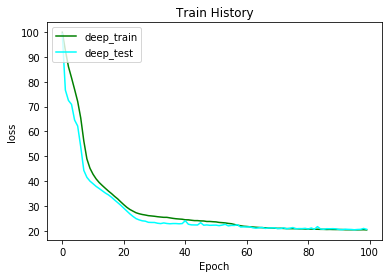

In [73]:
show_train_history('loss', 'val_loss')

| Model | 特徵 | MAPE |
| --- | --- | --- |
| output = ReLU | 建物移轉總面積, 建物, 鄉鎮市區 | 27% |
| output = ReLU | 建物移轉總面積, 建物, 鄉鎮市區, 屋齡 | 21% |
| output = Linear | 建物移轉總面積, 建物, 鄉鎮市區, 屋齡 | 22% |
| output = Linear | 建物移轉總面積, 建物, 鄉鎮市區, 屋齡, 車位 | 20% |
| output = ReLU | 建物移轉總面積, 建物, 鄉鎮市區, 屋齡, 車位 | 20% |
| output = ReLU | 建物移轉總面積, 建物, 鄉鎮市區, 屋齡,都市土地使用分區 | 19% |